# Naive Bayes

### Dataset Information
No. of Features: 10  
No. of Instances: 4492  
-- data captured at 5 second interval


### Table of Contents

1. [Data Ingestion](#data ingestion)
2. [Features & Target Arrays](#features and target arrays)
3. [GaussianNB](#naive bayes)
    1. [Classification Report](#classification report)
    2. [Confusion Matrix](#confusion matrix)
4. [Save Model](#pickle)

## Data Ingestion<a name='data ingestion'></a>

In [1]:
%matplotlib inline

import os
from urllib.request import urlopen, urlretrieve
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('RdBu', 10)

In [ ]:
url = 'https://raw.githubusercontent.com/georgetown-analytics/classroom-occupancy/master/models/sensor_updated_ml.csv'

In [ ]:
from urllib.request import urlretrieve

urlretrieve(url, 'sensor_updated_ml.csv')

In [2]:
# Import as pandas dataframe with DateTimeIndex: df
df = pd.read_csv('sensor_updated_ml.csv', index_col='datetime', parse_dates=True)

In [3]:
# Rename columns
df.columns = ['temp', 'humidity', 'co2', 'light', 'light_st', 'noise',
              'bluetooth', 'images', 'door', 'occupancy_count']

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4492 entries, 2017-03-25 09:05:00 to 2017-06-10 16:47:00
Data columns (total 10 columns):
temp               4492 non-null float64
humidity           4492 non-null float64
co2                4492 non-null float64
light              4492 non-null float64
light_st           4492 non-null float64
noise              4492 non-null float64
bluetooth          4492 non-null float64
images             4492 non-null float64
door               4492 non-null float64
occupancy_count    4492 non-null float64
dtypes: float64(10)
memory usage: 386.0 KB


,temp,humidity,co2,light,light_st,noise,bluetooth,images,door,occupancy_count
datetime,,,,,,,,,,
2017-03-25 09:05:00,22.600000,36.900000,781.000000,430.000000,1.0,511.000000,1.000000,15.242697,0.000000,0.000000
2017-03-25 09:06:00,23.800000,38.954167,765.465279,428.533744,1.0,503.515931,11.399457,15.242697,0.000000,0.000000
2017-03-25 09:07:00,23.850000,38.900000,768.458333,423.576500,1.0,510.548913,19.916667,15.242697,0.083333,4.416667
2017-03-25 09:08:00,23.900000,38.766667,777.791667,423.053571,1.0,506.504630,29.750000,15.242697,0.000000,23.416667
2017-03-25 09:09:00,23.908333,38.733333,770.864583,438.607904,1.0,500.092672,35.860577,15.242697,0.000000,30.000000


### Features & Target Arrays<a name='features and target arrays'></a>

In [5]:
# Create target array by slicing 'occupancy_count' column: occupancy_level
df['occupancy_level'] = pd.cut(df['occupancy_count'], [0, 1, 16, 27, 45],
                               labels=['empty', 'low', 'mid-level', 'high'], include_lowest=True)

In [6]:
# Breakdown of classroom occupancy levels
df.occupancy_level.value_counts(sort=False)

empty         482
low           348
mid-level     781
high         2881
Name: occupancy_level, dtype: int64

In [7]:
# Encode multiclass target variable
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(['empty', 'low', 'mid-level', 'high']).transform(df.occupancy_level)

array([0, 0, 2, ..., 2, 2, 2], dtype=int64)

In [8]:
from sklearn.model_selection import TimeSeriesSplit

X = df.drop('occupancy_level', axis=1).values
y = df['occupancy_level'].values

tscv = TimeSeriesSplit(n_splits=12)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## GaussianNB Model<a name='naive bayes'></a>

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Create feature and target arrays
X = df.drop('occupancy_level', axis=1)
y = df['occupancy_level']

# Create a GaussianNB classifer object: bayes
bayes = GaussianNB()

print('Naive Bayes Cross-Validation Scores')
cv_scores = cross_val_score(bayes, X, y, cv=tscv)
print(cv_scores)
print('Average 12-Fold CV Score: {}'.format(np.mean(cv_scores)))

Naive Bayes Cross-Validation Scores
[ 0.7826087   0.86086957  0.93913043  0.8115942   0.34202899  0.91014493
  0.90724638  0.94782609  0.79130435  0.76811594  0.98550725  0.97681159]
Average 12-Fold CV Score: 0.8352657004830918


#### Classification Report<a name='classification report'></a>

In [10]:
from sklearn.metrics import classification_report

# Fit GaussianNB classifier onto the training data: bayes
bayes = GaussianNB().fit(X_train, y_train)

# Predict test set labels: y_pred
y_pred = bayes.predict(X_test)

print('Naive Bayes Classification Report')
print(classification_report(y_test, y_pred))
print('Training set score: {:.4f}'.format(bayes.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(bayes.score(X_test, y_test)))

Naive Bayes Classification Report
             precision    recall  f1-score   support

      empty       1.00      1.00      1.00        61
       high       0.98      0.99      0.98       198
        low       0.95      1.00      0.98        41
  mid-level       0.95      0.87      0.91        45

avg / total       0.98      0.98      0.98       345

Training set score: 0.9619
Test set score: 0.9768


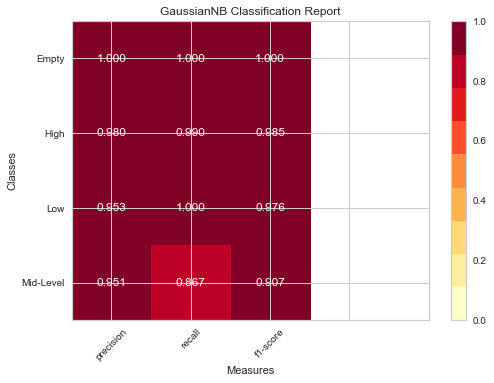

In [13]:
from yellowbrick.classifier import ClassificationReport
classes = ['Empty', 'High', 'Low', 'Mid-Level']

visualizer = ClassificationReport(bayes, classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
plt.savefig('bayes_classification_report.png')

#### Confusion Matrix <a name='confusion matrix'></a>

In [14]:
from sklearn.metrics import confusion_matrix

print('Naive Bayes Confusion Matrix')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Naive Bayes Confusion Matrix
Confusion Matrix
[[ 61   0   0   0]
 [  0 196   0   2]
 [  0   0  41   0]
 [  0   4   2  39]]


trying
trying
trying
trying
trying
trying
trying
trying
trying
trying


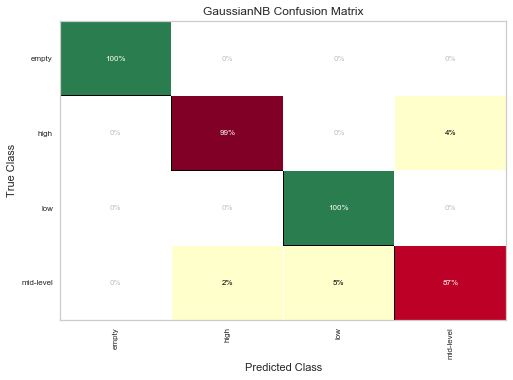

In [15]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(bayes)
cm.score(X_test, y_test)
cm.poof()
plt.savefig('bayes_confusion_matrix.png')

#### Class Balance<a name='class balance'></a>
Shows the support for each class in the fitted classification model.

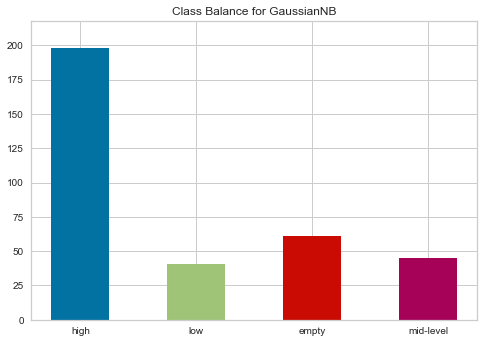

In [16]:
from yellowbrick.classifier import ClassBalance

visualizer = ClassBalance(bayes)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
plt.savefig('bayes_class_balance.png')

## Save Model<a name='pickle'></a>

In [ ]:
import pickle

bayes_model = 'bayes_model.sav'

# Save fitted model to disk
pickle.dump(bayes, open(bayes_model, 'wb'))